<a href="https://colab.research.google.com/github/indhu68/Intro_to_ML_project/blob/main/FNN_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import torch.optim as optim
torch.set_printoptions(edgeitems=2, linewidth=75)
torch.manual_seed(123)

In [2]:
from sklearn.metrics import accuracy_score, classification_report

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:

data = pd.read_csv('Desktop/ML_Final_Project/train_dataframe.csv')

# Remove the 'label' column and store it separately
removed_column = data.pop('label')  # Assuming 'label' is the name of the column to be removed
Y = pd.DataFrame({'age group': removed_column})

# Remaining data
X = data.values



In [5]:
sc = StandardScaler()
X = sc.fit_transform(X)
X.shape

(30694, 23)

In [6]:
label_mapping = {label: idx for idx, label in enumerate(np.unique(Y['age group']))}
Y = np.array([label_mapping[label] for label in Y['age group']])
X = torch.tensor(X, dtype=torch.float32)
Y.shape

(30694,)

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)







In [8]:

import torch.nn as nn
import torch.optim as optim
import numpy as np
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 256)  # Using hidden_size here too
        self.fc3 = nn.Linear(256, hidden_size)  # And here
        self.fc4 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x




In [9]:
from sklearn.utils.class_weight import compute_class_weight

def compute_class_weights(y):
    class_weights = compute_class_weight(  class_weight = 'balanced', classes = np.unique(y),y =  y)
    return class_weights

# Calculate class weights based on class distribution
class_weights = compute_class_weights(y_train)

# Convert class weights to a PyTorch tensor
class_weights_tensor =  torch.FloatTensor(class_weights).to(device)

# Use weighted cross-entropy loss
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)


In [10]:
input_size = X_train.shape[1]
hidden_size = 128  # You can adjust this based on your problem
output_size = len(np.unique(y_train))
# Now, when instantiating the model, it should match:
model = SimpleNN(input_size, hidden_size, output_size).to(device)
X_train_tensor = X_train_tensor.to(device)  # Move training data to GPU
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)  # Move test data to GPU
y_test_tensor = y_test_tensor.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [11]:
num_epochs = 500
batch_size = 32
for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        inputs = X_train_tensor[i:i+batch_size]
        labels = y_train_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            train_outputs = model(X_train_tensor)
            val_outputs = model(X_test_tensor)
            _, train_predicted = torch.max(train_outputs, 1)
            train_accuracy = accuracy_score(y_train, train_predicted.cpu().numpy())
            _, test_predicted = torch.max(val_outputs, 1)
            test_accuracy = accuracy_score(y_test, test_predicted.cpu().numpy())  # Move back to CPU for metrics
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Training Accuracy: {train_accuracy * 100:.2f}%, Validation Accuracy: {test_accuracy * 100:.2f}%')
        model.train()

Epoch [100/500], Loss: 0.7593, Training Accuracy: 71.71%, Validation Accuracy: 64.59%
Epoch [200/500], Loss: 0.4344, Training Accuracy: 81.18%, Validation Accuracy: 70.78%
Epoch [300/500], Loss: 0.5410, Training Accuracy: 85.33%, Validation Accuracy: 72.80%
Epoch [400/500], Loss: 0.4241, Training Accuracy: 87.72%, Validation Accuracy: 74.31%
Epoch [500/500], Loss: 0.3172, Training Accuracy: 89.22%, Validation Accuracy: 74.91%


In [12]:
# Load the data from the URL
#data_url = "https://raw.githubusercontent.com/indhu68/Intro_to_ML_project/main/test_dataframe.csv"
data = pd.read_csv('Desktop/ML_Final_Project/test_dataframe.csv')


# Remove the 'label' column and store it separately
removed_column = data.pop('label')  # Assuming 'label' is the name of the column to be removed
Y = pd.DataFrame({'age group': removed_column})

# Remaining data
X = data.values
sc = StandardScaler()
X = sc.fit_transform(X)
label_mapping = {label: idx for idx, label in enumerate(np.unique(Y['age group']))}
y_test = np.array([label_mapping[label] for label in Y['age group']])
X_test= torch.tensor(X, dtype=torch.float32)
X_test_tensor = torch.FloatTensor(X_test)
X_test_tensor = X_test_tensor.to(device)

Accuracy on the test set: 72.70%


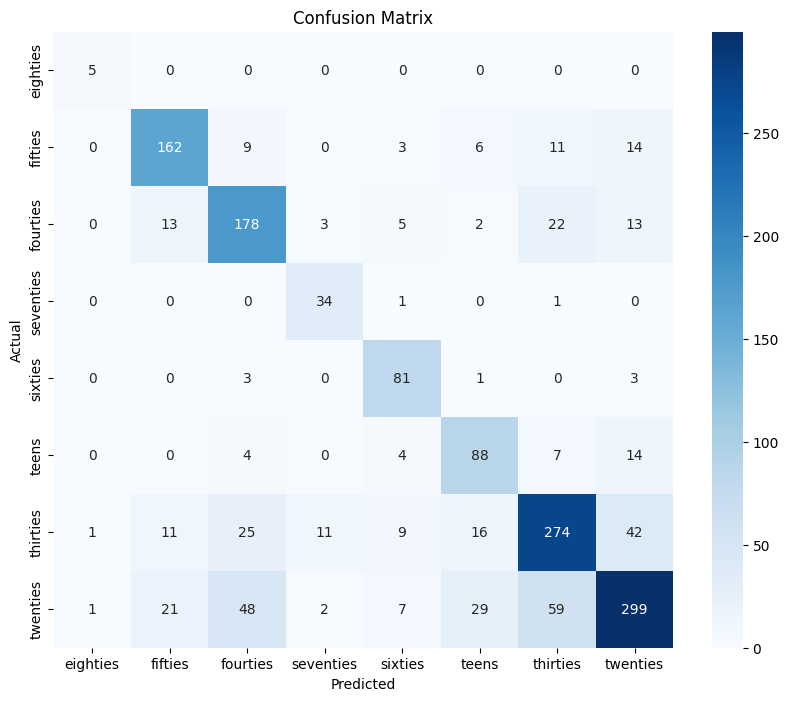

              precision    recall  f1-score   support

    eighties       0.71      1.00      0.83         5
     fifties       0.78      0.79      0.79       205
    fourties       0.67      0.75      0.71       236
   seventies       0.68      0.94      0.79        36
     sixties       0.74      0.92      0.82        88
       teens       0.62      0.75      0.68       117
    thirties       0.73      0.70      0.72       389
    twenties       0.78      0.64      0.70       466

    accuracy                           0.73      1542
   macro avg       0.71      0.81      0.75      1542
weighted avg       0.73      0.73      0.73      1542



In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
    accuracy = accuracy_score(y_test, predicted.cpu().numpy())  # Move back to CPU for metrics
    print(f'Accuracy on the test set: {accuracy * 100:.2f}%')

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predicted.cpu().numpy())

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=predicted_labels, yticklabels=predicted_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Convert predicted labels back to original age group strings
predicted_labels = [label for label, idx in label_mapping.items() if idx in y_test]
print(classification_report(y_test, predicted.cpu().numpy(), target_names=predicted_labels))
